In [22]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def softmax(coeffs):
    """ 计算给定x的系数的softmax """
    exps = np.exp(coeffs)
    return exps / np.sum(exps)

def p(t, coeffs, T=1):
    """ 计算时间 t 的 softmax 归一化的多项式试探解 """
    x = t / T
    terms = np.array([x**i for i in range(1, len(coeffs)+1)])
    weights = softmax(coeffs)
    return np.dot(weights, terms)

def theta(t, c0, T=1):
    """ 计算角度 theta(t) """
    pt = p(t, c0, T)
    return (np.pi / 2) * pt**2 * np.sin(np.pi / 2 * pt)**2

def alpha(t, c1, a0, b0, T=1):
    """ 计算 alpha(t) """
    pt = p(t, c1, T)
    return a0 + (b0 - a0) * pt**2 * np.sin(np.pi / 2 * pt)**2


def beta(t, c0, c1, a0, b0, T=1):
    """ 计算 beta(t) """
    thetat = theta(t, c0, T)
    alphat = alpha(t, c1, a0, b0, T)
    return (b0 - alphat * np.sin(thetat)**2) / np.cos(thetat)**2

def V(x, y, t, c0, c1, a0, b0, T=1):
    """ 计算势能 V(x, y, t) """
    thetat = theta(t, c0, T)
    alphat = alpha(t, c1, a0, b0, T)
    betat = beta(t, c0, c1, a0, b0, T)
    return 0.5 * alphat * (np.cos(thetat) * x + np.sin(thetat) * y)**2 + \
           0.5 * betat * (np.cos(thetat) * y - np.sin(thetat) * x)**2


ValueError: x and y must have same first dimension, but have shapes (100,) and (99,)

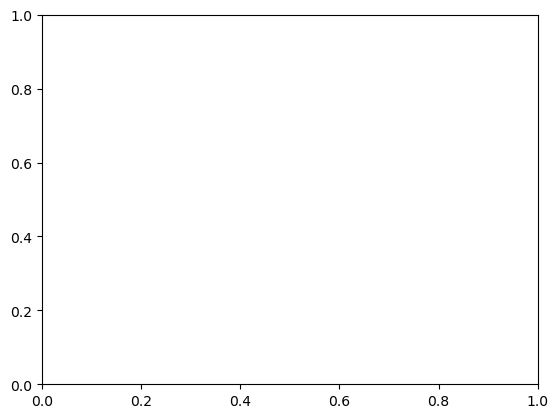

In [23]:
def hamiltonian_equations(t, state, c0, c1, a0, b0, Cc, m, T=1):
    x1, y1, x2, y2, px1, py1, px2, py2 = state
    # 计算V对x1, y1, x2, y2的偏导数
    Vx1 = (alpha(t, c1, a0, b0, T) * (np.cos(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * x1 + np.sin(theta(t, c0, T)) * y1)) -
           beta(t, c0, c1, a0, b0, T) * np.sin(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * y1 - np.sin(theta(t, c0, T)) * x1))
    Vy1 = (alpha(t, c1, a0, b0, T) * (np.sin(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * x1 + np.sin(theta(t, c0, T)) * y1)) +
           beta(t, c0, c1, a0, b0, T) * np.cos(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * y1 - np.sin(theta(t, c0, T)) * x1))
    Vx2 = (alpha(t, c1, a0, b0, T) * (np.cos(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * x2 + np.sin(theta(t, c0, T)) * y2)) -
           beta(t, c0, c1, a0, b0, T) * np.sin(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * y2 - np.sin(theta(t, c0, T)) * x2))
    Vy2 = (alpha(t, c1, a0, b0, T) * (np.sin(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * x2 + np.sin(theta(t, c0, T)) * y2)) +
           beta(t, c0, c1, a0, b0, T) * np.cos(theta(t, c0, T)) * (np.cos(theta(t, c0, T)) * y2 - np.sin(theta(t, c0, T)) * x2))

    # 计算Coulomb力对x1, y1, x2, y2的偏导数
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    F_coulomb_x = Cc * (x1 - x2) / (r**3)
    F_coulomb_y = Cc * (y1 - y2) / (r**3)

    # 哈密顿方程
    dot_x1 = px1 / m
    dot_y1 = py1 / m
    dot_x2 = px2 / m
    dot_y2 = py2 / m
    dot_px1 = -Vx1 + F_coulomb_x
    dot_py1 = -Vy1 + F_coulomb_y
    dot_px2 = -Vx2 - F_coulomb_x
    dot_py2 = -Vy2 - F_coulomb_y

    return [dot_x1, dot_y1, dot_x2, dot_y2, dot_px1, dot_py1, dot_px2, dot_py2]

# 参数
c0 = [1, 0, 0]  # 示例参数，需要根据具体情况调整
c1 = [1, 0, 0]  # 示例参数，需要根据具体情况调整
a0 = 1
b0 = 2
Cc = 1  # Coulomb常数，需要根据具体情况调整
m = 1   # 质量
T = 1   # 总时间
x0 = (Cc / 4 / a0) ** (1/3)

# 初始条件
initial_state = [x0, 0, -x0, 0, 0, 0, 0, 0]

# 时间区间
t_span = (0, T)
t_eval = np.linspace(0, T, 100)

# 解微分方程
solution = solve_ivp(hamiltonian_equations, t_span, initial_state, args=(c0, c1, a0, b0, Cc, m, T), t_eval=t_eval)

# 绘图
plt.plot(t_eval, solution.y[0], label='x1')
plt.plot(t_eval, solution.y[1], label='y1')
plt.plot(t_eval, solution.y[2], label='x2')
plt.plot(t_eval, solution.y[3], label='y2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Time Evolution of the System')
plt.show()


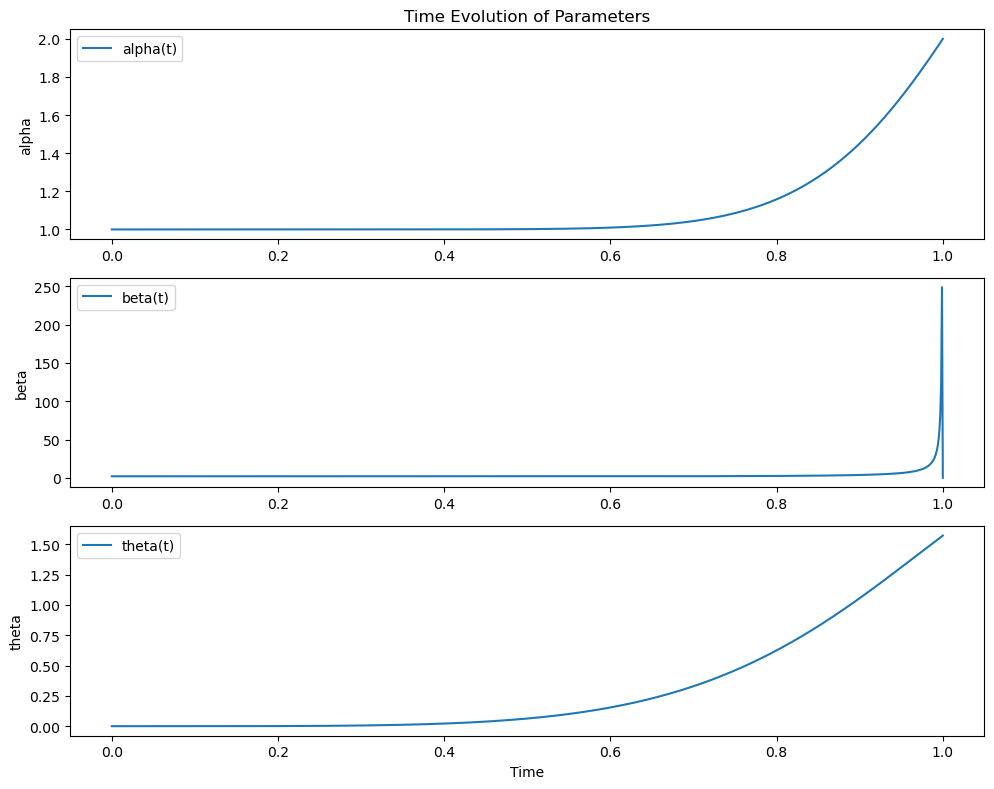

In [24]:
# 时间点
t_points = np.linspace(0, T, 1000)

# 计算 alpha, beta, theta
alpha_values = [alpha(t, c1, a0, b0, T) for t in t_points]
beta_values = [beta(t, c0, c1, a0, b0, T) for t in t_points]
theta_values = [theta(t, c0, T) for t in t_points]

# 绘图
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t_points, alpha_values, label='alpha(t)')
plt.ylabel('alpha')
plt.title('Time Evolution of Parameters')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_points, beta_values, label='beta(t)')
plt.ylabel('beta')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_points, theta_values, label='theta(t)')
plt.ylabel('theta')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

In [120]:
import numpy as np
from scipy.integrate import solve_ivp
import math
from scipy.interpolate import BSpline
from scipy.special import softmax
import scipy.constants as consts

# 定义参数
m = 171 * consts.atomic_mass

b0 = (2.0 * (2 * np.pi) * 1e6)**2 * m

a0 = (1.0 * (2 * np.pi) * 1e6)**2 * m

C_c = consts.elementary_charge ** 2 / 4 / np.pi / consts.epsilon_0

T = 1e-5
chara_time = 1e-6
T /= chara_time

chara_length = (C_c / 4 / a0) ** (1/3)
chara_energy = C_c / chara_length
chara_mass = chara_energy / chara_length ** 2 * chara_time ** 2

m /= chara_mass

a0 *= chara_length ** 2
b0 *= chara_length ** 2
C_c /= chara_length


a0 /= chara_energy
b0 /= chara_energy
C_c /= chara_energy



def create_i_splines(n, degree=3):
    """创建 n 个 I-Spline 基函数."""
    interior_knots = np.linspace(0, 1, n - degree + 1)
    knots = np.concatenate(([0]*degree, interior_knots, [1]*degree))
    coefficients = np.eye(n)
    splines = [BSpline(knots, coefficients[i], degree).antiderivative() for i in range(n)]
    return [lambda x, s=s: s(x)/s(1) for s in splines]

def p(t, coeffs, splines):
    """计算时间 t 的 softmax 归一化的 I-Spline 试探解."""
    x = t / T
    weights = softmax(coeffs)
    spline_values = np.array([spline(x) for spline in splines])
    return np.dot(weights, spline_values)

def c_t(t, c2, splines):
    """时间依赖的c(t), 依赖于参数 c2."""
    return -b0 / 24 * np.sin(math.pi * p(t, c2, splines))**2

def a_t(t, c1, splines):
    """时间依赖的a(t), 依赖于参数 c1."""
    return 2 * (b0 - a0) * np.sin(math.pi / 2 * p(t, c1, splines))**2

def V(x, y, t, c1, c2, splines):
    """时间依赖的势能函数."""
    return 0.5 * (a0 + a_t(t, c1, splines)) * x**2 + 0.5 * b0 * y**2 + c_t(t, c2, splines) * x * y

def dynamics(t, y, c1, c2, splines):
    """微分方程的右侧."""
    x1, vx1, y1, vy1, x2, vx2, y2, vy2 = y
    ax1 = -(a0 + a_t(t, c1, splines)) * x1 - c_t(t, c2, splines) * y1
    ay1 = -b0 * y1 - c_t(t, c2, splines) * x1
    ax2 = -(a0 + a_t(t, c1, splines)) * x2 - c_t(t, c2, splines) * y2
    ay2 = -b0 * y2 - c_t(t, c2, splines) * x2
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    Fx = C_c * (x1 - x2) / (r**3)
    Fy = C_c * (y1 - y2) / (r**3)
    return [vx1, (ax1 + Fx) / m, vy1, (ay1 + Fy) / m, vx2, (ax2 - Fx) / m, vy2, (ay2 - Fy) / m]

def solve_dynamics(c1, c2, splines):
    """解动力学方程."""
    x1_0 = 1
    
    y1_0 = 0
    x2_0 = -x1_0
    y2_0 = 0
    initial_conditions = [x1_0, 0, y1_0, 0, x2_0, 0, y2_0, 0]
    solution = solve_ivp(dynamics, [0, T], initial_conditions, args=(c1, c2, splines), method='RK45')
    return solution

# 示例参数
c1_example = np.ones(4)  # 示例的参数c1
c2_example = np.ones(4)  # 示例的参数c2
splines = create_i_splines(4)  
solution = solve_dynamics(c1_example, c2_example, splines)
print(solution.t)  # 打印时间点
print(solution.y)  # 打印解


[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.07267003e-01 2.18156111e-01 3.50635817e-01 4.76979072e-01
 5.96104504e-01 7.38638664e-01 8.97626974e-01 1.03038551e+00
 1.16222043e+00 1.32037664e+00 1.46387234e+00 1.59404145e+00
 1.72421055e+00 1.85363317e+00 1.98305580e+00 2.11927844e+00
 2.23539146e+00 2.35131854e+00 2.46345119e+00 2.57558383e+00
 2.67810996e+00 2.78024311e+00 2.87873757e+00 2.97723202e+00
 3.06990779e+00 3.16258356e+00 3.25402135e+00 3.34545915e+00
 3.43312418e+00 3.51880828e+00 3.60539711e+00 3.69198595e+00
 3.77285858e+00 3.85344984e+00 3.93738634e+00 4.02132283e+00
 4.09925390e+00 4.17694135e+00 4.25928848e+00 4.34120956e+00
 4.41926512e+00 4.49686007e+00 4.57999632e+00 4.66209920e+00
 4.74826520e+00 4.83443119e+00 4.92549854e+00 5.01417489e+00
 5.11286928e+00 5.21156367e+00 5.30263654e+00 5.40541691e+00
 5.47132045e+00 5.53489588e+00 5.58648760e+00 5.63786619e+00
 5.68923245e+00 5.74296905e+00 5.80278435e+00 5.86034971e+00
 5.91791506e+00 5.983092

In [107]:
a0, b0, C_c, m

(0.25000000000000056, 1.0000000000000022, 1.0, 0.006332573977646126)

In [132]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import math

# 之前定义的函数与参数保持不变
T = 10
def total_mechanical_energy(solution, c1, c2, splines):
    """计算给定参数和解下的末态总机械能."""
    x1, vx1, y1, vy1, x2, vx2, y2, vy2 = solution.y[:, -1]
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    kinetic_energy = 0.5 * m * (vx1**2 + vy1**2 + vx2**2 + vy2**2)
    potential_energy = V(x1, y1, solution.t[-1], c1, c2, splines) + V(x2, y2, solution.t[-1], c1, c2, splines) + C_c / r
    return kinetic_energy + potential_energy

# 目标函数调整为包括 splines
def objective_function(params, splines):
    """目标函数：最小化末态总机械能."""
    n = len(params) // 2
    c1, c2 = params[:n], params[n:]
    solution = solve_dynamics(c1, c2, splines)
    return total_mechanical_energy(solution, c1, c2, splines)

# 初始化参数
initial_params = np.ones(8)  # 假设使用4个系数控制 c1 和 c2
n = len(initial_params) // 2
splines = create_i_splines(n)  
# 使用COBYLA方法找到最小化末态总机械能的参数
result = minimize(lambda params: objective_function(params, splines), initial_params, method='Nelder-Mead')

print("Optimization Result:", result)


Optimization Result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.1911225591592913
             x: [ 1.296e+02 -1.574e+02 -4.864e+01  1.296e+02  8.142e+00
                  2.959e+01  2.958e+01 -2.588e+01]
           nit: 625
          nfev: 1081
 final_simplex: (array([[ 1.296e+02, -1.574e+02, ...,  2.958e+01,
                        -2.588e+01],
                       [ 1.296e+02, -1.574e+02, ...,  2.958e+01,
                        -2.588e+01],
                       ...,
                       [ 1.296e+02, -1.574e+02, ...,  2.958e+01,
                        -2.588e+01],
                       [ 1.296e+02, -1.574e+02, ...,  2.958e+01,
                        -2.588e+01]]), array([ 1.191e+00,  1.191e+00,  1.191e+00,  1.191e+00,
                        1.191e+00,  1.191e+00,  1.191e+00,  1.191e+00,
                        1.191e+00]))


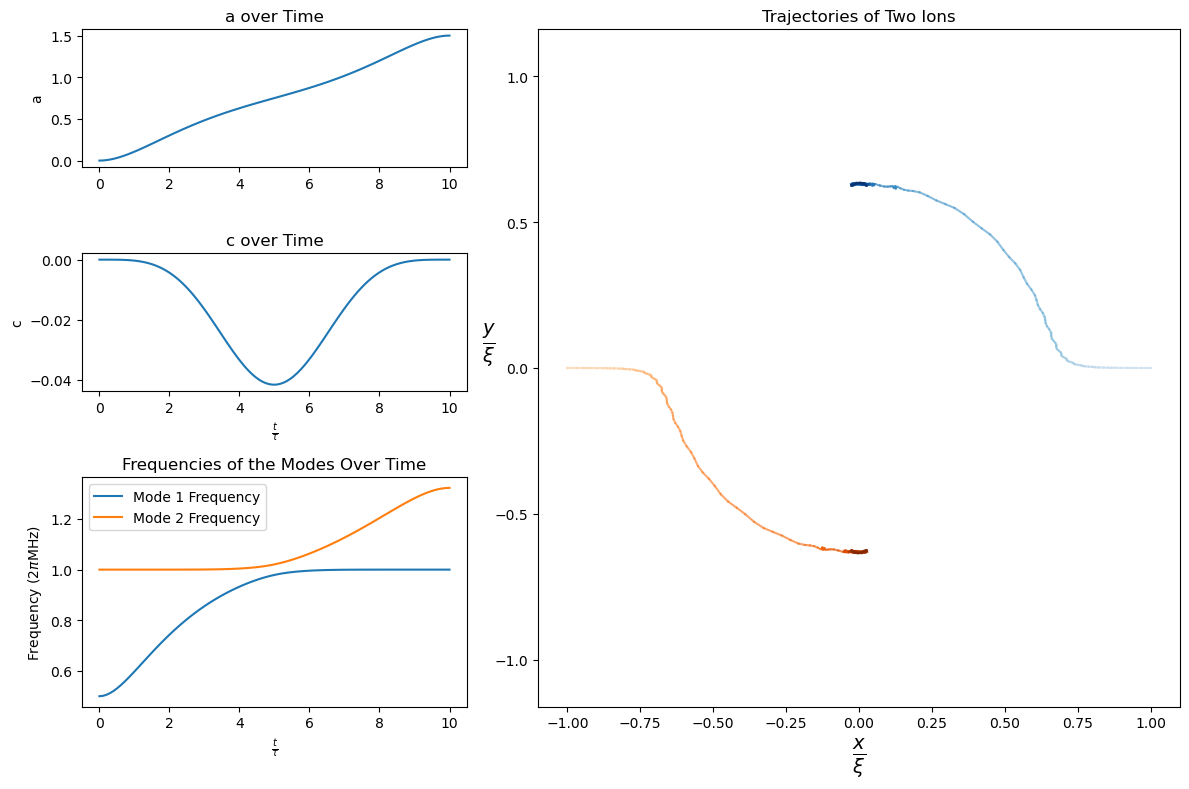

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib import cm
import matplotlib.gridspec as gridspec

# Assuming functions like create_i_splines, solve_dynamics, a_t, c_t are already defined

def visualize_custom_layout(params, splines):
    n = len(params) // 2
    c1, c2 = params[:n], params[n:]
    num_points = 100
    t_values = np.linspace(0, T, num_points)

    # Data for a(t) and c(t)
    a_values = [a_t(t, c1, splines) for t in t_values]
    c_values = [c_t(t, c2, splines) for t in t_values]

    # Data for frequencies
    freqs = []
    for t in t_values:
        H = np.array([
            [a0 + a_t(t, c1, splines), c_t(t, c2, splines)],
            [c_t(t, c2, splines), b0]
        ])
        evals, _ = eigh(H)
        freqs.append(np.sqrt(evals))
    freqs = np.array(freqs)

    # Data for trajectories
    solution = solve_dynamics(c1, c2, splines)
    t, x1, y1, x2, y2 = solution.t, solution.y[0], solution.y[2], solution.y[4], solution.y[6]
    num_points_traj = len(t)
    colors1 = plt.cm.Blues(np.linspace(0.2, 1, num_points_traj))
    colors2 = plt.cm.Oranges(np.linspace(0.2, 1, num_points_traj))

    ## Step 1: Create a figure
    fig = plt.figure(figsize=(12, 8))  # You can adjust the figure size as needed

    # Step 2: Define the GridSpec layout
    gs = gridspec.GridSpec(3, 2, height_ratios=[3, 3, 5], width_ratios=[3,5])  # 3 rows, 2 columns

    # Step 3: Allocate subplots to the grid
    # Left column for a(t), c(t) and frequencies
    ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Second row, first column, sharing x-axis with ax1
    ax3 = fig.add_subplot(gs[2, 0])  # Third row, first column

    # Right column for trajectories, spanning all left rows
    ax4 = fig.add_subplot(gs[:, 1])  # All rows, second column

    # Plot a(t) and c(t) in the upper left quadrant
    ax1.plot(t_values, a_values, label='a(t)')
    ax1.set_ylabel('a')
    ax1.set_title('a over Time')

    ax2.plot(t_values, c_values, label='c(t)')
    ax2.set_xlabel(r'$\frac{t}{\tau}$')
    ax2.set_ylabel('c')
    ax2.set_title('c over Time')

    # Plot frequencies in the lower left quadrant
    ax3.plot(t_values, freqs[:, 0], label='Mode 1 Frequency')
    ax3.plot(t_values, freqs[:, 1], label='Mode 2 Frequency')
    ax3.set_xlabel(r'$\frac{t}{\tau}$')
    ax3.set_ylabel(r'Frequency ($2\pi$MHz)')
    ax3.legend()
    ax3.set_title('Frequencies of the Modes Over Time')

    # Plot trajectories in the right half
    for i in range(num_points_traj - 1):
        ax4.plot([x1[i], x1[i+1]], [y1[i], y1[i+1]], color=colors1[i], alpha=0.7)
        ax4.plot([x2[i], x2[i+1]], [y2[i], y2[i+1]], color=colors2[i], alpha=0.7)
    ax4.set_xlabel(r'$\frac{x}{\xi}$', fontsize=20)
    ax4.set_ylabel(r'$\frac{y}{\xi}$', fontsize=20, rotation=0)
    ax4.set_title('Trajectories of Two Ions')
    ax4.axis('equal')

    plt.tight_layout()
    plt.show()

T = 10
optimization_result = result.x  # Assume this is the optimized parameters
splines = create_i_splines(4)  # Create basis functions

# Visualize
visualize_custom_layout(optimization_result, splines)


In [150]:
def V(x, y, t, c1, c2, splines):
    """时间依赖的势能函数."""
    # print("V", t)
    # print((a0 + a_t(t, c1, splines)), x)
    # print(0.5 * (a0 + a_t(t, c1, splines)) * x**2)
    return 0.5 * (a0 + a_t(t, c1, splines)) * x**2 + 0.5 * b0 * y**2 + c_t(t, c2, splines) * x * y

def total_mechanical_energy(solution, c1, c2, splines):
    """计算给定参数和解下的末态总机械能."""
    x1, vx1, y1, vy1, x2, vx2, y2, vy2 = solution.y[:, -1]
    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    kinetic_energy = 0.5 * m * (vx1**2 + vy1**2 + vx2**2 + vy2**2)
    potential_energy = V(x1, y1, solution.t[-1], c1, c2, splines) + V(x2, y2, solution.t[-1], c1, c2, splines) + C_c / r
    print(x1,y1,x2,y2)
    print(kinetic_energy, potential_energy)
    # print(V(x1, y1, solution.t[-1], c1, c2, splines) , V(x2, y2, solution.t[-1], c1, c2, splines))
    return kinetic_energy + potential_energy

# 目标函数调整为包括 splines
def objective_function(params, splines):
    """目标函数：最小化末态总机械能."""
    n = len(params) // 2
    c1, c2 = params[:n], params[n:]
    solution = solve_dynamics(c1, c2, splines)
    return total_mechanical_energy(solution, c1, c2, splines)

x = (C_c / (4 * b0))**(1/3)
min_potential = b0 * x ** 2 + C_c / 2 / x 

E = objective_function(result.x, splines) 

heating = (E - min_potential) * chara_energy / consts.hbar / (2 * (2 * np.pi) * 1e6)
heating

0.017369947900266157 0.6324867701644409 -0.017369947900266157 -0.6324867701644409
0.000322619713537005 1.1907999394457542


57.658754004533485

# Adiabatic Trajectory

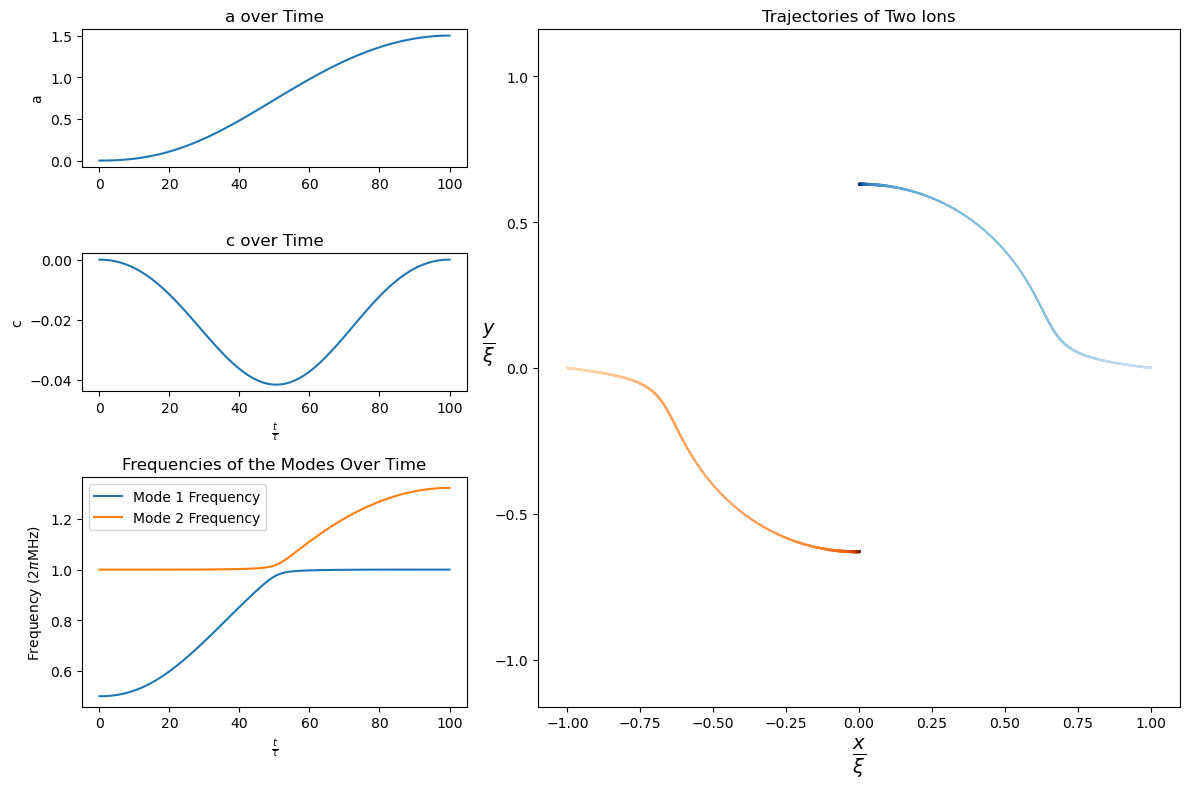

In [157]:
T = 100
visualize_custom_layout(np.random.uniform(size=8), splines)

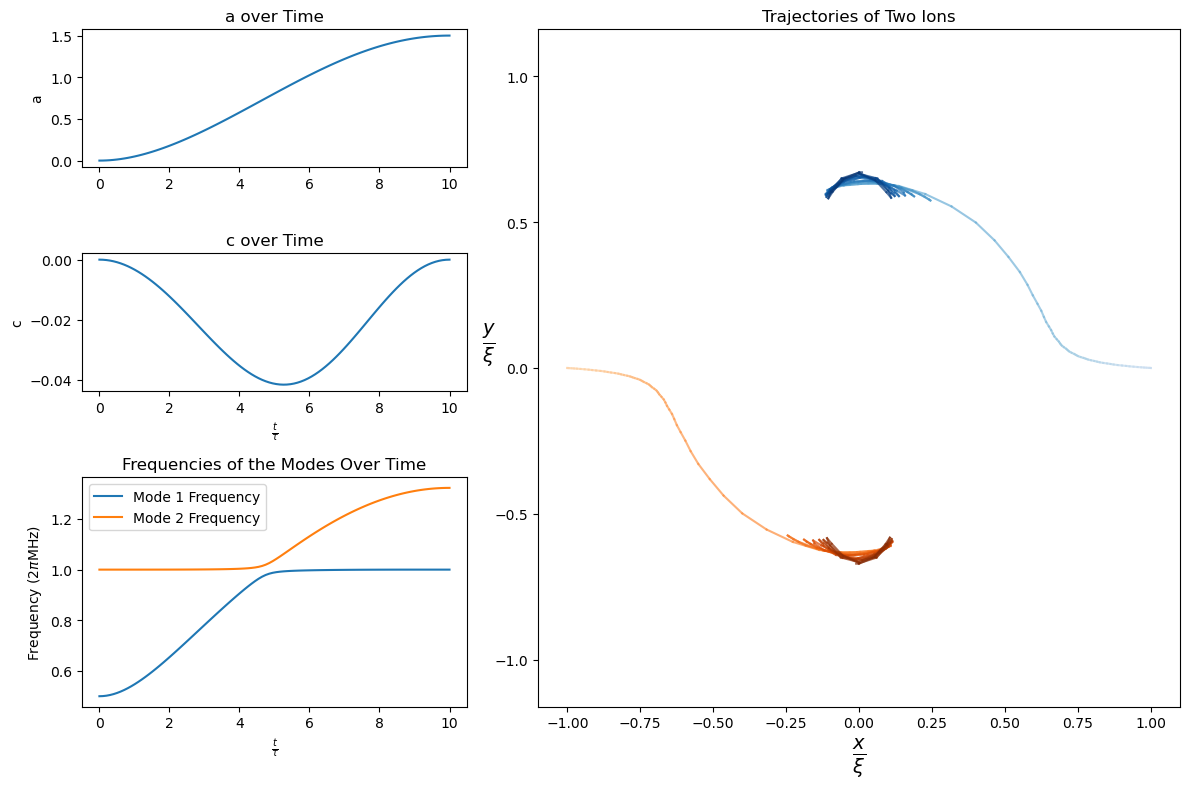

In [158]:
T = 10
visualize_custom_layout(np.random.uniform(size=8), splines)